### [Gaussian Mixtures](https://scikit-learn.org/stable/modules/mixture.html)
- GMs are probabilistic models that assume all data comes from a set of Gaussian distributions with unknown parameters.
- They use the [expectation-maximization (EM)](https://scikit-learn.org/stable/modules/mixture.html#expectation-maximization) algorithm for model fitting. 
- They can draw *confidence ellipsoids* for multivariate models.
- They can find the *Bayesian Info Criterion (BIC)* to assess the number of clusters in the data.
- Once fitted, a GM can assign test samples to a most likely Gaussian using `predict`.
- Different *covariance matrix* options are supported:
    - spherical
    - diagonal
    - tied
    - full

### Expectation Maximization (EM)
- Unlabeled GM problems are made so by not knowing which samples came from which latent (hidden) component. 
- EM resolves this with an iterative approach. It first assumes random components & finds, for each sample, a probability of it being generated from each component in the model. Parameters are tweaked to maximize their likelihoods given those assignments. Repeating this process guarantees converging to (at least) a local optimum. 

### [Example: GMM clustering, Iris toy dataset](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)
- Plots predicted labels on training & test data using multiple GMM covariance types.
- Training data = dots; test data = crosses.
- Iris toy dataset is 4-dimensional - only the first two are used.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture as GM
from sklearn.model_selection import StratifiedKFold as SKF

In [2]:
colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            
        v, w = np.linalg.eigh(covariances) # eigenvectors, eigenvalues of Hessian matrix
        u    = w[0] / np.linalg.norm(w[0]) # norm
        
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        
        # Ellipse(xy, width, height[, angle])
        ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], 180+angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

In [3]:
# split data into non-overlapping training (75%) and testing (25%) sets.
# Only take the first fold.

iris                    = datasets.load_iris()
skf                     = SKF(n_splits=4)
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))
X_train                 = iris.data[train_index]
y_train                 = iris.target[train_index]
X_test                  = iris.data[test_index]
y_test                  = iris.target[test_index]
n_classes               = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GM(n_components=n_classes,
                           covariance_type=cov_type, 
                           max_iter=20, 
                           random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

/tmp/ipykernel_101926/3491200273.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], 180+angle, color=color)
/tmp/ipykernel_101926/3491200273.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], 180+angle, color=color)
/tmp/ipykernel_101926/3491200273.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], 180+angle, color=color)
/tmp/ipykernel_101926/3491200273.py:23: MatplotlibDeprecationWarning: Passin

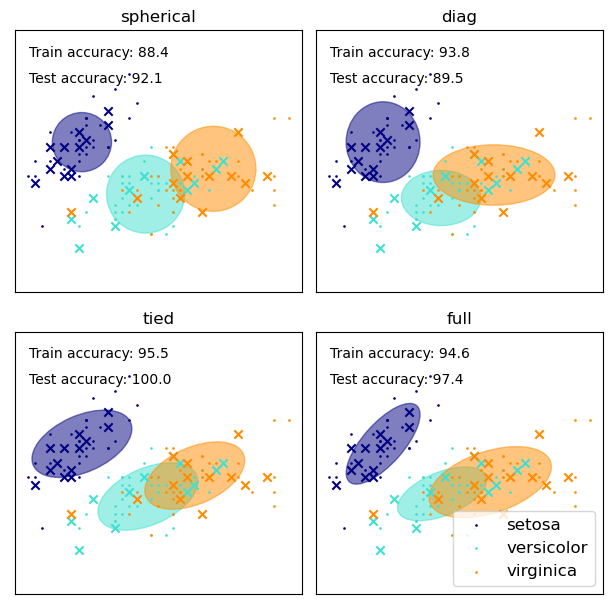

In [4]:
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)

# Since we have class labels for the training data, we can
# initialize the GMM parameters in a supervised manner.

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    estimator.fit(X_train) # Train other parameters using EM

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n])

    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred   = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100

    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy, transform=h.transAxes)

    y_test_pred   = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy, transform=h.transAxes)

    plt.xticks(()); plt.yticks(()); plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

### [Example - Gaussian Mixtures - Density Estimation](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py)
- Data is generated from two Gaussians with different centers & covariance matrices.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture as GM

- 1) spherical data centered at (20,20)
- 2) zero-centered stretched Gaussian
- Stack 1+2
- concatenate into final training set


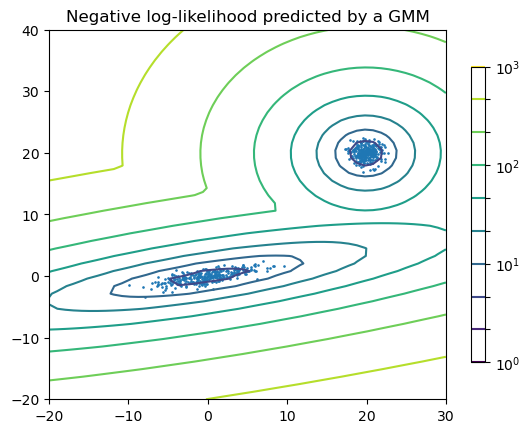

In [6]:
n = 300
np.random.seed(0)

shifted_gaussian   = np.random.randn(n,2) + np.array([20, 20])
C                  = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n,2), C)
X_train            = np.vstack([shifted_gaussian, stretched_gaussian])

clf = GM(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x    = np.linspace(-20., 30.)
y    = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX   = np.array([X.ravel(), Y.ravel()]).T
Z    = -clf.score_samples(XX)
Z    = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8) #, extend='both')

plt.scatter(X_train[:, 0], X_train[:, 1], .8)
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

### [ Example: Using Bayes Info Criterion (BIC) to select #Components](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py)
- Model Selection concerns both the *covariance type* & *number of model components*. AIC also provides a correct result (not shown) - BIC is better if the problem is identify the right model.

In [7]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [8]:
# Generate random sample, two components
n = 500
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n, 2), C),
          .7 * np.random.randn(n, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic        = []
n_range    = range(1, 7)
cv_types  = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic        = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf        = best_gmm
bars       = []

/tmp/ipykernel_101926/351211558.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)


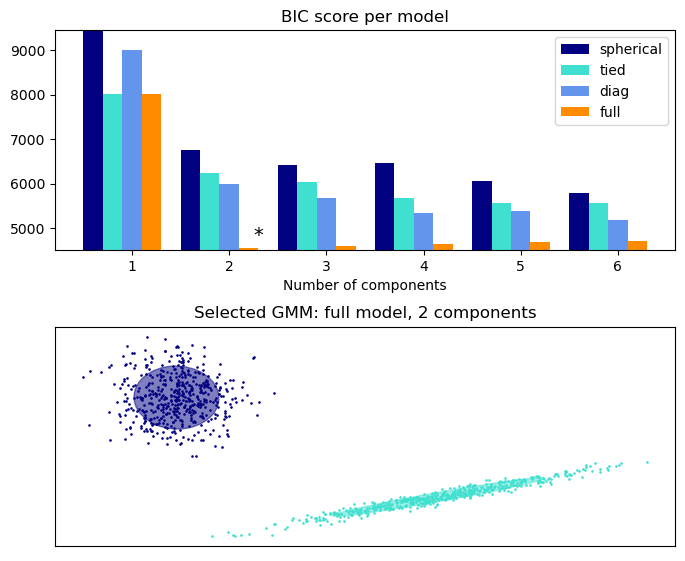

In [9]:
plt.figure(figsize=(8, 6)) # Plot the BIC scores

spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_range)+0.2*(i-2)
    
    bars.append(plt.bar(xpos, bic[i*len(n_range):
                                  (i+1)*len(n_range)],
                        width=0.2, 
                        color=color))

plt.xticks(n_range)
plt.ylim([bic.min()*1.01-0.01*bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), len(n_range)) + 0.65 + 0.2 * np.floor(bic.argmin() / len(n_range))

plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

### [Variational Bayesian GM](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture)
- *Variational inference* is an extension of EM. It *maximizes a lower bound* on model evidence, including priors, instead of data likelihood.
- Variational methods add *regularization* by using information from prior distributions. This avoids the singularities found in some EM solutions, but introduces some biases.
- Inference is notably slower.
- Variational inference requires more parameters due to its Bayes background. The most important is `weight_concentration_prior`.
    - low values cause the model to more heavily weigh a few components, while setting the remaining weights to zero.
    - high values add a larger proportion of components to the mix.
- Two types of priors are available for the weights distribution:
    - A *finite mixture* model with a *Dirichlet distribution*
    - An *infinite mixture* model with the Dirichlet process. (In practice, this algorithm is usually approximated & uses a truncated, "stick-breaking" representation.)

### [Example: Concentration Prior Analysis - Variational Bayesian GMs](https://scikit-learn.org/stable/auto_examples/mixture/plot_concentration_prior.html)
- Generate a toy dataset (mixture of 3 Gaussians)
- Fit with a `Bayes GM` using 1) a *Dirichlet distribution prior* (`weight_concentration_prior="dirichlet_distribution"`) and 2) a *Dirichlet process prior* (`weight_concentration_prior="dirichlet_process"`).
- Plot the ellipsoids for the three values of the weight concentration prior.

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.mixture import BayesianGaussianMixture as BGM

In [11]:
# dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means   = np.array([[.0, -.70],
                    [.0, .0],
                    [.0, .70]])

In [12]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])                 # eigenvectors, eigenvalues
        unit_eig_vec       = eig_vecs[0] / np.linalg.norm(eig_vecs[0]) # norms

        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        angle = 180 * angle / np.pi                                    # mp.patches.Ellipse needs degrees
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)                  # eigenvector normalization

        ell = mpl.patches.Ellipse(means[n], 
                                  eig_vals[0], 
                                  eig_vals[1],
                                  180 + angle, 
                                  edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)

In [13]:
def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)

    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w,          width=0.9, color='#56B4E9', zorder=3, align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),      horizontalalignment='center')

    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')

In [14]:
# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture, Dirichlet distribution\nprior and " r"$\gamma_0=$", 
     BGM(weight_concentration_prior_type="dirichlet_distribution",
         n_components=2 * n_components, 
         reg_covar=0, 
         init_params='random',
         max_iter=1500, 
         mean_precision_prior=.8,
         random_state=random_state), [0.001, 1, 1000]),
    
    ("Infinite mixture, Dirichlet process\n prior and" r"$\gamma_0=$",
     BGM(weight_concentration_prior_type="dirichlet_process",
         n_components=2 * n_components, 
         reg_covar=0, 
         init_params='random',
         max_iter=1500, 
         mean_precision_prior=.8,
         random_state=random_state), [1, 1000, 100000])]

In [15]:
# Generate data
rng = np.random.RandomState(random_state)

X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])

y = np.concatenate([np.full(samples[j], j, dtype=int)
                    for j in range(n_components)])

/tmp/ipykernel_101926/1212577513.py:10: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(means[n],
/tmp/ipykernel_101926/1212577513.py:10: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(means[n],
/tmp/ipykernel_101926/1212577513.py:10: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(means[n],
/tmp/ipykernel_101926/1212577513.py:10: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two mino

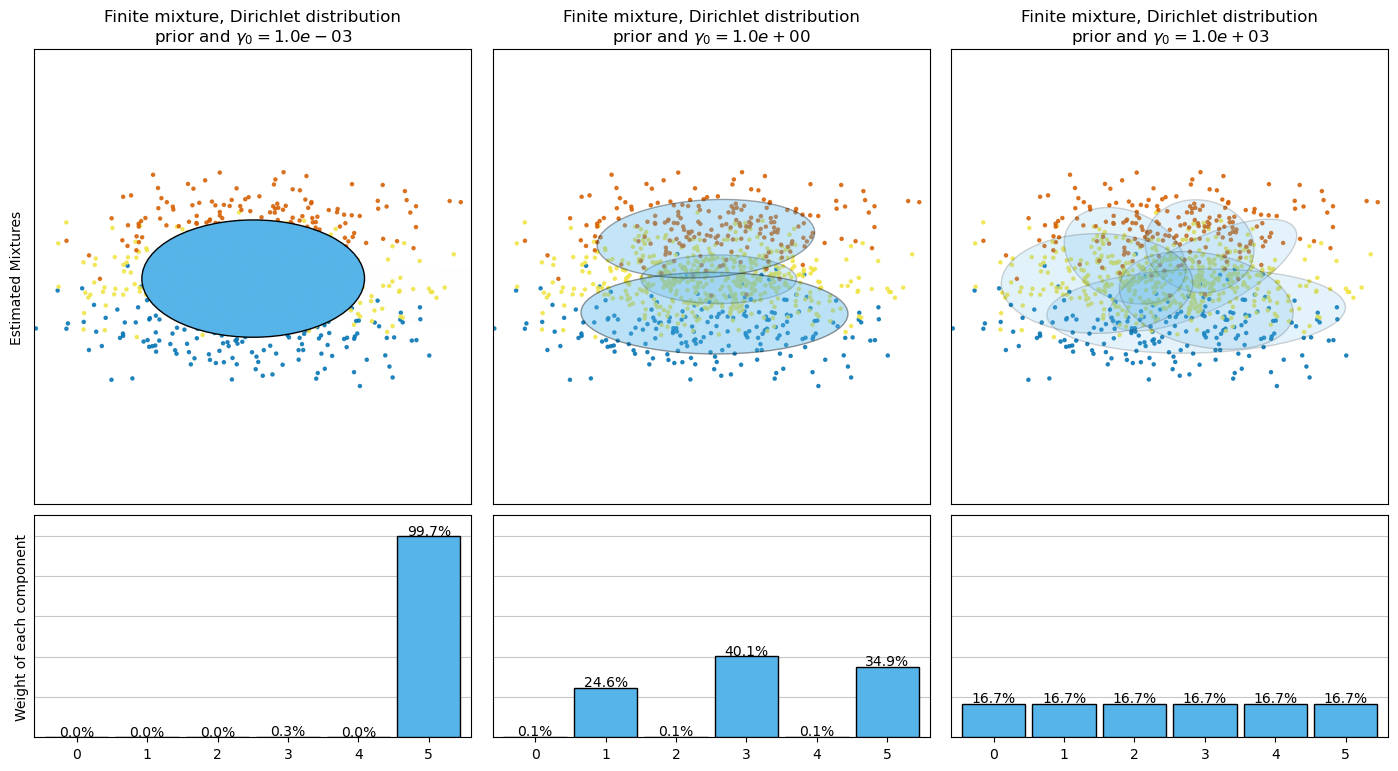

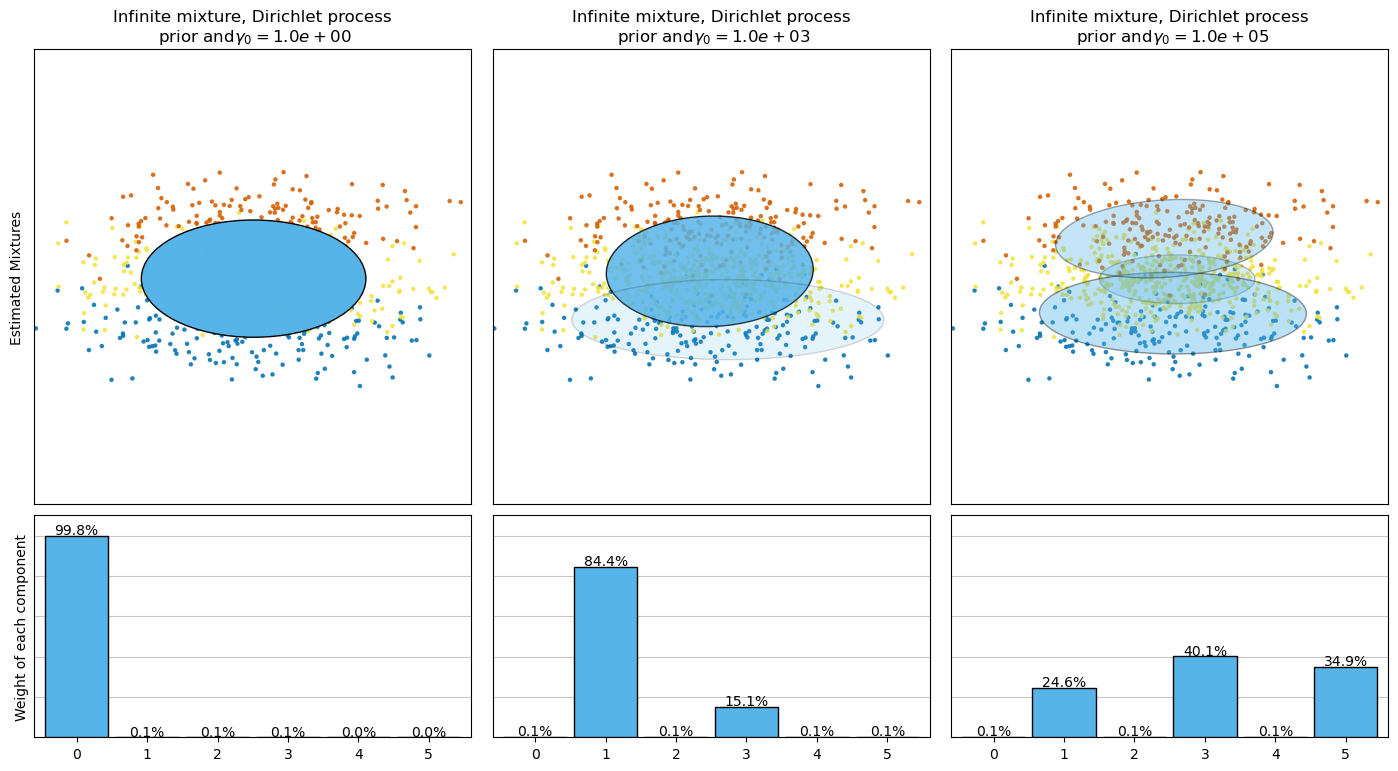

In [16]:
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))

    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()

### [Example: GM Confidence Ellipsoids, EM vs VI](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html)
- Plot the confidence ellipsoids of two Gaussians
- Compare results obtained via Expectation Maximization with Variational Inference
- Both models can access five components for fitting.
    - EM uses all
    - VI uses only what it needs for a "good fit".
- EM apparently splits some components arbitrarily as it tries to fit too many components.
- VI adapts the number of available components.
- (Not shown in this example) the Dirichlet process model can fit *full covariance matrices* even when there are less #samples/cluster than #dimensions - due to regularization.

In [17]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [18]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v    = 2. * np.sqrt(2.) * np.sqrt(v)
        u    = w[0] / linalg.norm(w[0])
        
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/tmp/ipykernel_101926/1901597720.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
/tmp/ipykernel_101926/1901597720.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)


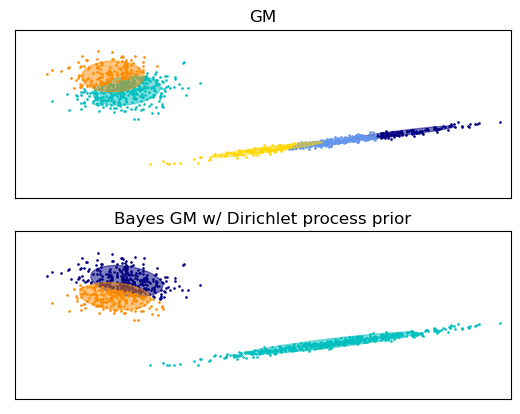

In [19]:
n = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n, 2), C),
          0.7 *  np.random.randn(n, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
# Fit a Dirichlet process Gaussian mixture using five components

gmm   = mixture.GaussianMixture(        n_components=5, covariance_type='full').fit(X)
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)

plot_results(X, gmm.predict(X),     gmm.means_,   gmm.covariances_, 0, 'GM')
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1, 'Bayes GM w/ Dirichlet process prior')

plt.show()

### [Example: GMM w/ Sinuoidal data](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_sin.html)
- Demostrates GMM behavior on non-Gaussian data (in this case 100 points on a noisy sine curve).
- Therefore, *no ground truth* for the number of Gaussian components.
- *1st model*: classic GMM, 10 components, fit using EM.

- *2nd model*: Bayesian GMM, Dirichlet process prior lower concentration prior setting
    - result: lower number of active components. The model "decides" to focus its attention on the big-picture dataset structure (groups of points in alternating directions, modeled by non-diagonal covariance matrices.)
    
- *3rd model*: Bayesian GMM, Dirichlet process prior, higher concentration prior setting
    - result: higher number of active components

In [20]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [21]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [22]:
def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [23]:
n = 100

# Generate random sample following a sine curve
np.random.seed(0)
X    = np.zeros((n, 2))
step = 4.0*np.pi/n

for i in range(X.shape[0]):
    x       = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))


/tmp/ipykernel_101926/289741984.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
/tmp/ipykernel_101926/289741984.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
/tmp/ipykernel_101926/289741984.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)


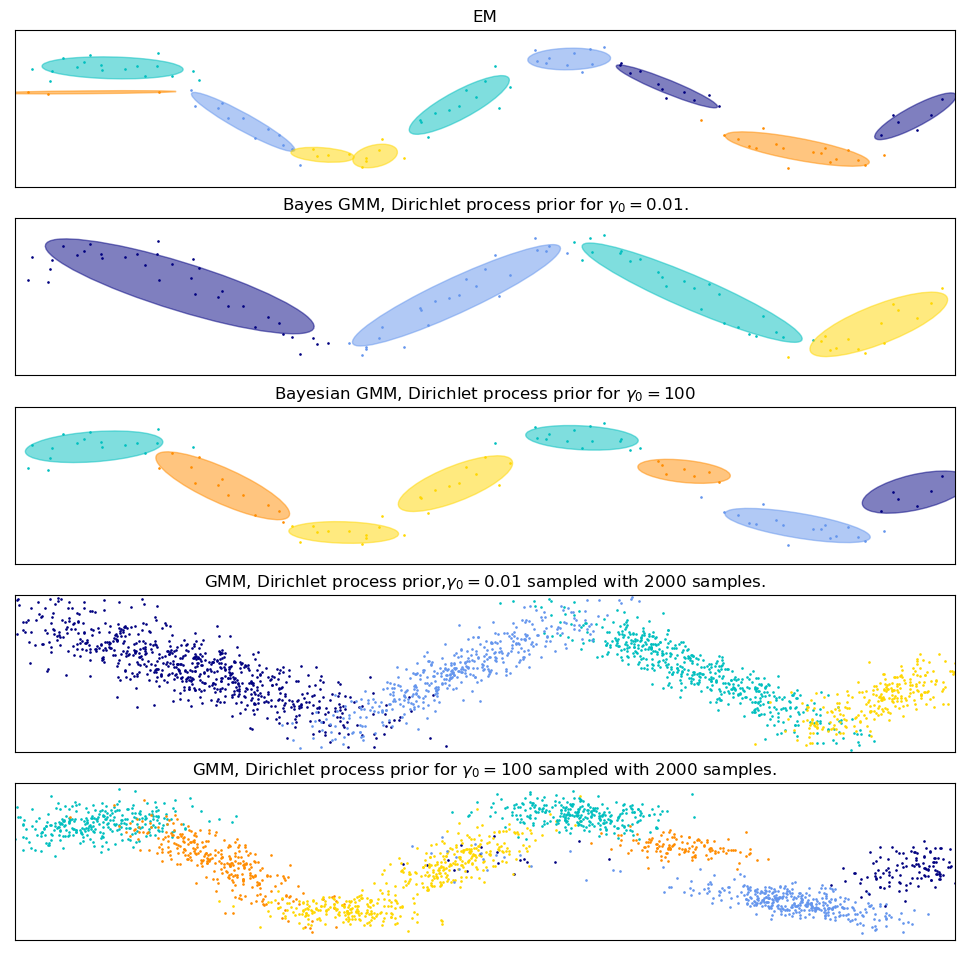

In [24]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, 
                              covariance_type='full',
                              max_iter=100).fit(X)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, 
    covariance_type='full', 
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, 
    covariance_prior=1e0 * np.eye(2),
    init_params="random", 
    max_iter=100, 
    random_state=2).fit(X)

plot_results(X,   gmm.predict(X),   gmm.means_,   gmm.covariances_, 0, 'EM')
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1, "Bayes GMM, Dirichlet process prior "r"for $\gamma_0=0.01$.")

X_s, y_s = dpgmm.sample(n_samples=2000)

plot_samples(X_s, y_s, dpgmm.n_components, 0, "GMM, Dirichlet process prior,"r"$\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, 
    covariance_type='full', 
    weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, 
    covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", 
    max_iter=100, 
    random_state=2).fit(X)

plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian GMM, Dirichlet process prior "r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)

plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "GMM, Dirichlet process prior "r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()